In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import NLTKWordTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize.nist import NISTTokenizer
import numpy as np
import nltk

In [3]:
data = pd.read_json('new_train.json')
data.columns = ["id", "text", "author"]
data.head()

,id,text,author
0,id10914,"It will have been, by that time, totally destr...",EAP
1,id03295,"Make me happy, and I shall again be virtuous.""",MWS
2,id04103,"The margin of the river, and of the many dazzl...",EAP
3,id26189,The heat became all at once intolerable.,EAP
4,id07955,"What, indeed, was my passion for the young gir...",EAP


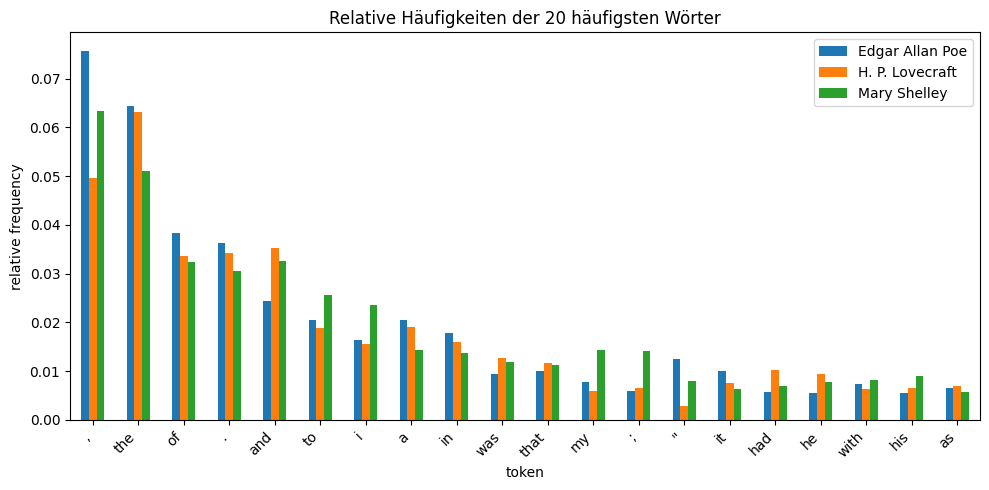

In [13]:
from nltk import FreqDist
from nltk import word_tokenize

authors_short_dict = {"MWS": "Mary Shelley",
                      "HPL": "H. P. Lovecraft", "EAP": "Edgar Allan Poe"}

def to_words(x):
    x = x.lower()
    return  NISTTokenizer().tokenize(x)

all_words = data.copy()
all_words.text = all_words.text.apply(to_words)
all_words = all_words.groupby('author').agg(
    text = pd.NamedAgg("text", aggfunc=lambda x: len([token for sentence in x for token in sentence ]))
)
all_words = all_words.pivot_table(columns=all_words.index)

df = data.copy()
df.text = df.text.apply(to_words)
per_author = df.groupby('author').agg(
    text = pd.NamedAgg("text", aggfunc=lambda x: [token for sentence in x for token in sentence ])
)
per_author = per_author.text.apply(lambda x: pd.Series(x).value_counts())
per_author = per_author.pivot_table(columns=per_author.index, fill_value=0)
for column in per_author.columns:
    per_author[column] = per_author[column] / all_words[column][0]
per_author = per_author.filter(items=df.text.explode().value_counts().index[:20], axis=0)
per_author = per_author.rename_axis("", axis=1)
per_author = per_author.rename(columns=lambda x: authors_short_dict[x])
per_author.plot.bar(figsize=(10, 5), rot=45, ylabel="relative frequency", xlabel="token", title="Relative Häufigkeiten der 20 häufigsten Wörter")
plt.xticks(ha="right")
plt.tight_layout()
plt.savefig("presentation/feature_exploration_words.png", dpi=300)

/tmp/ipykernel_2053/258215875.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  per_author = per_author.text.apply(lambda x: pd.Series(x).value_counts())


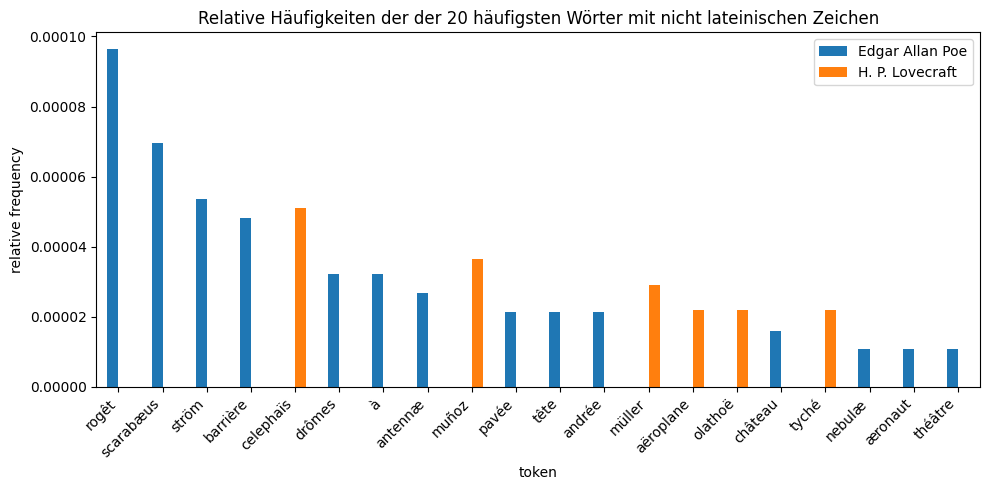

In [14]:
def is_diacritic(x):
    return not x.isascii()

df = data.copy()
df.text = df.text.apply(lambda x: list(filter(is_diacritic, to_words(x))))
per_author = df.groupby('author').agg(
    text = pd.NamedAgg("text", aggfunc=lambda x: [token for sentence in x for token in sentence ])
)
per_author = per_author.text.apply(lambda x: pd.Series(x).value_counts())
per_author = per_author.pivot_table(columns=per_author.index, fill_value=0)
for column in per_author.columns:
    per_author[column] = per_author[column] / all_words[column][0]
per_author = per_author.filter(items=df.text.explode().value_counts().index[:20], axis=0)
per_author = per_author.rename_axis("", axis=1)
per_author = per_author.rename(columns=lambda x: authors_short_dict[x])
per_author.plot.bar(figsize=(10, 5), rot=45, ylabel="relative frequency", xlabel="token", title="Relative Häufigkeiten der der 20 häufigsten Wörter mit nicht lateinischen Zeichen")
plt.xticks(ha="right")
plt.tight_layout()
plt.savefig("presentation/feature_exploration_non_latin.png", dpi=300)

# non ascii elements are used so rarely that we expect them to get eliminated by a high pass filter

In [ ]:
import string

def contains_punctuation(s: str) -> bool:
    for punct in string.punctuation:
        if s.__contains__(punct):
            return True
    return False

print(string.punctuation)
for doc in per_author:
    text = word_tokenize(doc)
    print(FreqDist(filter(contains_punctuation, text)).most_common(100))

# All authors do of course use similar punctuation, but there seems enough variation in relative frequency to hypothesize that punctuation constitutes a good stylomatic feature

In [ ]:
for doc in per_author:
    text = map(lambda x: x.lower(), word_tokenize(doc))
    print(FreqDist(filter(lambda x: x.__contains__("'"), text)).most_common(10))

# all authors use contractions to different degrees. Because we are looking for stylomatic featuers we recommend not eliminating contractions.
# The noise we see from filtering for the use of an apostrophe will be eliminated by the high pass filter

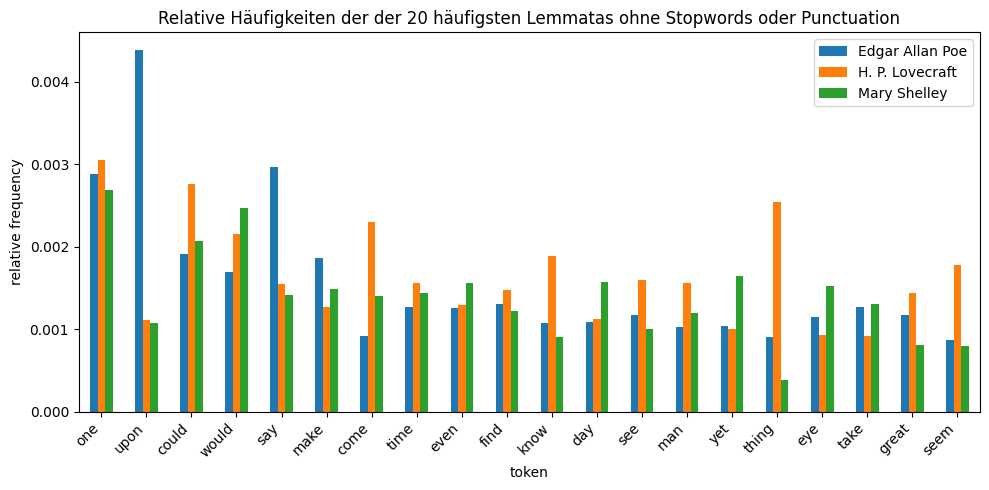

In [15]:
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))
def filter_sp(x):
    return not x in stop_words

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lmtzr = WordNetLemmatizer()
def preprocess_WL(x):
    x = to_words(x)
    x = list(filter(lambda x: not x in stop_words and not x in string.punctuation, x))
    x = pos_tag(x)
    return [lmtzr.lemmatize(token, tag_map[tag[0]]) for token, tag in x]

df = data.copy()
df.text = df.text.apply(preprocess_WL)
per_author = df.groupby('author').agg(
    text = pd.NamedAgg("text", aggfunc=lambda x: [token for sentence in x for token in sentence ])
)
per_author = per_author.text.apply(lambda x: pd.Series(x).value_counts())
per_author = per_author.pivot_table(columns=per_author.index, fill_value=0)
for column in per_author.columns:
    per_author[column] = per_author[column] / all_words[column][0]
per_author = per_author.filter(items=df.text.explode().value_counts().index[:20], axis=0)
per_author = per_author.rename_axis("", axis=1)
per_author = per_author.rename(columns=lambda x: authors_short_dict[x])
per_author.plot.bar(figsize=(10, 5), rot=45, ylabel="relative frequency", xlabel="token", title="Relative Häufigkeiten der der 20 häufigsten Lemmatas ohne Stopwords oder Punctuation")
plt.xticks(ha="right")
plt.tight_layout()
plt.savefig("presentation/feature_exploration_lemmatization.png", dpi=300)


In [ ]:
for doc in per_author:
    text = ''.join(list(map(lambda x: x.lower(), word_tokenize(doc))))
    new_text = []
    for i in range(len(text)):
        if i % 3 == 0 and i < len(text)-2:
            new_text.append(''.join([text[i], text[i+1], text[i+2]]))
    print(FreqDist(new_text).most_common(100))

# Classical n-grams won't work because they violate the bag of words assumption.
# We therefore consider chunks of size 3. We also remove whitespace. There seems to be a fair bit of variations between authors. So might might have to try this as well.

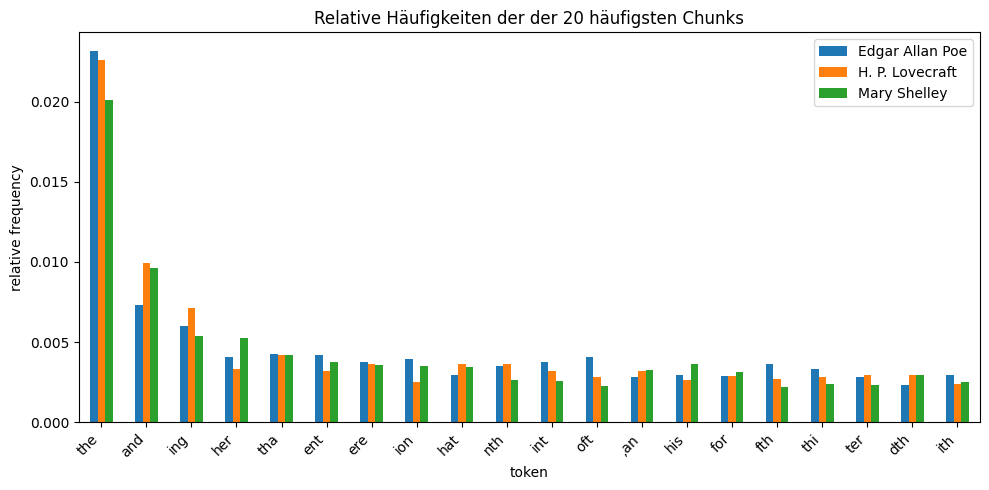

In [16]:
def to_chunks(x):
    x = "".join(to_words(x))
    new_text = []
    for i in range(len(x)):
        if i % 3 == 0 and i < len(x)-2:
            new_text.append(''.join([x[i], x[i+1], x[i+2]]))
    return new_text

all_chunks = data.copy()
all_chunks.text = all_chunks.text.apply(to_chunks)
all_chunks = all_chunks.groupby('author').agg(
    text = pd.NamedAgg("text", aggfunc=lambda x: len([token for sentence in x for token in sentence ]))
)
all_chunks = all_chunks.pivot_table(columns=all_chunks.index)

df = data.copy()
df.text = df.text.apply(to_chunks)
per_author = df.groupby('author').agg(
    text = pd.NamedAgg("text", aggfunc=lambda x: [token for sentence in x for token in sentence ])
)
per_author = per_author.text.apply(lambda x: pd.Series(x).value_counts())
per_author = per_author.pivot_table(columns=per_author.index, fill_value=0)
for column in per_author.columns:
    per_author[column] = per_author[column] / all_chunks[column][0]
per_author = per_author.filter(items=df.text.explode().value_counts().index[:20], axis=0)
per_author = per_author.rename_axis("", axis=1)
per_author = per_author.rename(columns=lambda x: authors_short_dict[x])
per_author.plot.bar(figsize=(10, 5), rot=45, ylabel="relative frequency", xlabel="token", title="Relative Häufigkeiten der der 20 häufigsten Chunks")
plt.xticks(ha="right")
plt.tight_layout()
plt.savefig("presentation/feature_exploration_chunks.png", dpi=300)

In [8]:
key_values = data.copy()
key_values.text = key_values.text.apply(to_words)
key_values

,id,text,author
0,id10914,"[it, will, have, been, ,, by, that, time, ,, t...",EAP
1,id03295,"[make, me, happy, ,, and, i, shall, again, be,...",MWS
2,id04103,"[the, margin, of, the, river, ,, and, of, the,...",EAP
3,id26189,"[the, heat, became, all, at, once, intolerable...",EAP
4,id07955,"[what, ,, indeed, ,, was, my, passion, for, th...",EAP
...,...,...,...
15658,id05743,"[one, other, thing, is, curious, .]",HPL
15659,id07540,"[despite, my, most, careful, searches, and, in...",HPL
15660,id10121,"[the, conversation, then, reverted, to, asiati...",MWS
15661,id11494,"[but, the, little, chap, seized, him, at, once...",EAP


In [9]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.axis import Axis  

results = pd.DataFrame()
results["Länge"] = key_values.text.apply(lambda x: len(x))
results["Vokabulargröße"] =  key_values.text.apply(lambda x: len(pd.Series(x).unique()))

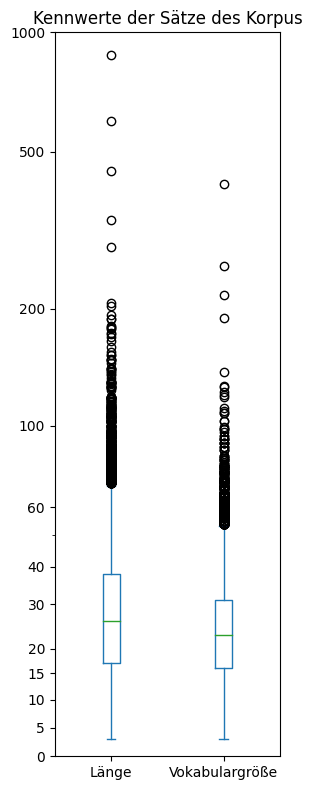

In [17]:
ax = results.plot.box(title="Kennwerte der Sätze des Korpus", figsize=(3, 8))
ax.set_yscale("asinh", linear_width=30)
Axis.set_major_formatter(ax.yaxis, ScalarFormatter())
ax.set_ylim(bottom=0)
ax.set_yticks([  0., 5 ,  10., 15, 20, 30, 40, 60 , 100., 200, 500, 1000])
plt.tight_layout()
plt.savefig("presentation/feature_exploration_corpus.png", dpi=300)

In [ ]:
len(key_values.text.explode().unique())